<a href="https://colab.research.google.com/github/marriamaslova/compling_nlp_hse_course/blob/master/notebooks/rnn_ner/homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание № 8

In [ ]:
!pip install pandas scikit-learn matplotlib

In [ ]:
import tensorflow as tf

In [ ]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from tensorflow import keras

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

## Задание 1 (4 балла) 

Обучите 8 моделей для задачи классификации текста (датасет - lenta_40k ). А именно:  
1) модель с 1 GRU слоем;   
2) модель с 1 LSTM слоем    
3) модель с 1 GRU и 1 LSTM слоем  
4) модель с 1 BIGRU и 2 LSTM слоями  
5) модель с 5 GRU слоями и 3 LSTM слоями  
6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались   
7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM  



Параметр units и размер эмбединга можете задать любой. Оцените качество каждой модели и определите победителя.

In [ ]:
data = pd.read_csv('lenta_40k.csv')

In [ ]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [ ]:
from keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [ ]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [ ]:
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [ ]:
id2word = {i:word for word, i in word2id.items()}

In [ ]:
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [ ]:
MAX_LEN = max(len(x) for x in X)
MEAN_LEN = np.median([len(x) for x in X])
MAX_LEN = int(MEAN_LEN + 30)

In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [ ]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [ ]:
y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

Модель с одним GRU-слоем

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

rnn = tf.keras.layers.GRU(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


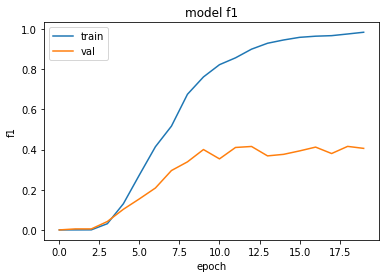

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(X_valid, y_valid, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.950900673866272
Test accuracy: 0.6167942881584167


Модель с одним LSTM-слоем

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

rnn = tf.keras.layers.LSTM(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


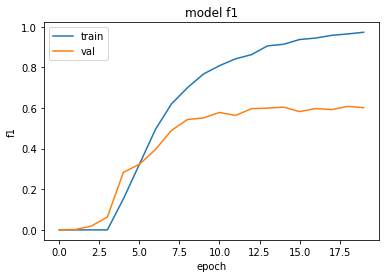

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(X_valid, y_valid, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.3251463174819946
Test accuracy: 0.6975099444389343


Модель с 1 GRU и 1 LSTM слоем

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

gru_1 = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
gru_2 = tf.keras.layers.LSTM(128, return_sequences=False)(gru_1)

dense = tf.keras.layers.Dense(64, activation='relu')(gru_2)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=200,
          epochs=15)

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


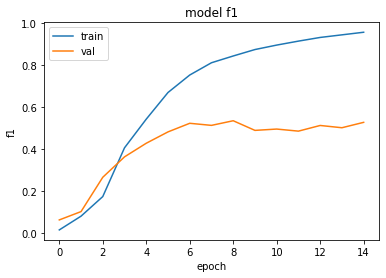

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(X_valid, y_valid, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.603376030921936
Test accuracy: 0.6633008718490601


Модель с 1 BIGRU и 2 LSTM слоями

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

gru_bi = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
gru_2 = tf.keras.layers.LSTM(128, return_sequences=True)(gru_bi)
gru_3 = tf.keras.layers.LSTM(130, return_sequences=False)(gru_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(gru_3)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=200,
          epochs=15)

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


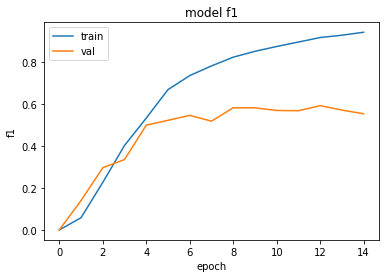

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(X_valid, y_valid, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.2358579635620117
Test accuracy: 0.6951665878295898


Модель с 5 GRU слоями и 3 LSTM слоями

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

gru_1 = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
gru_2 = tf.keras.layers.LSTM(128, return_sequences=True)(gru_1)
gru_3 = tf.keras.layers.GRU(128, return_sequences=True)(gru_2)
gru_4 = tf.keras.layers.LSTM(128, return_sequences=True)(gru_3)
gru_5 = tf.keras.layers.GRU(128, return_sequences=True)(gru_4)
gru_6 = tf.keras.layers.LSTM(128, return_sequences=True)(gru_5)
gru_7 = tf.keras.layers.GRU(128, return_sequences=True)(gru_6)
gru_8 = tf.keras.layers.GRU(130, return_sequences=False)(gru_7)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(gru_8)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=200,
          epochs=15)

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


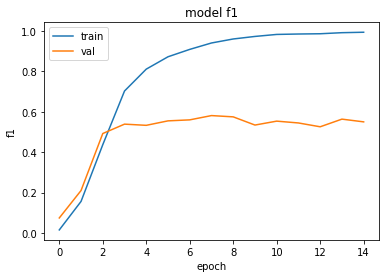

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(X_valid, y_valid, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.6718418598175049
Test accuracy: 0.6851969957351685


Модель c 1 BIGRU и 1 BILSTM слоями

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )

hidden_1 = tf.keras.layers.Bidirectional(
                                       tf.keras.layers.LSTM(128, return_sequences=True),
                        backward_layer=tf.keras.layers.LSTM(128, return_sequences=True, 
                                                            go_backwards=True))(embeddings)
hidden_2 = tf.keras.layers.Bidirectional(
                                       tf.keras.layers.GRU(128, return_sequences=False),
                        backward_layer=tf.keras.layers.GRU(128, return_sequences=False, 
                                                            go_backwards=True))(hidden_1)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(hidden_2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=200,
          epochs=15)

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


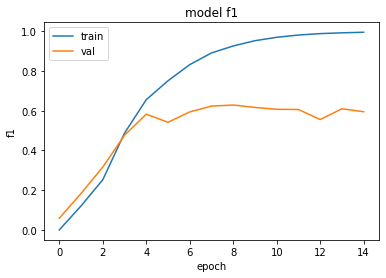

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(X_valid, y_valid, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.5563887357711792
Test accuracy: 0.7019110918045044


Модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

hidden_1 = tf.keras.layers.LSTM(128, return_sequences=True)(embeddings)
hidden_2 = tf.keras.layers.GRU(128, return_sequences=True)(hidden_1)
hidden_3 = tf.keras.layers.Bidirectional(
                                       tf.keras.layers.LSTM(128, return_sequences=True),
                        backward_layer=tf.keras.layers.LSTM(128, return_sequences=True, 
                                                            go_backwards=True))(hidden_2)
hidden_4 = tf.keras.layers.Bidirectional(
                                       tf.keras.layers.GRU(128, return_sequences=True),
                        backward_layer=tf.keras.layers.GRU(128, return_sequences=True, 
                                                            go_backwards=True))(hidden_3)
hidden_5 = tf.keras.layers.GRU(128, return_sequences=True)(hidden_4)
hidden_6 = tf.keras.layers.LSTM(128, return_sequences=False)(hidden_5)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(hidden_6)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=200,
          epochs=15)

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


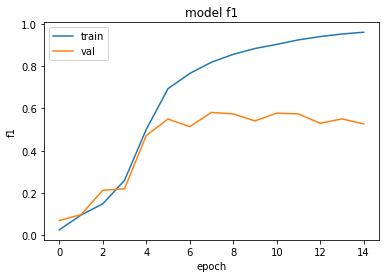

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(X_valid, y_valid, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.3723623752593994
Test accuracy: 0.6715415716171265


По получившейся оценке и по графику победила модель с 1 BIGRU и 1 BILSTM слоями.

## Задание 2 (6 баллов)


На данных википедии (wikiann) обучите 2 модели:  
1) модель в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев. 
1) модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев. 

Сравните качество по метрикам. Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [ ]:
dataset = load_dataset("wikiann", 'ru')

In [ ]:
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

In [ ]:
word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)

In [ ]:
id2word = {i:word for word, i in word2id.items()}

In [ ]:
X = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [ ]:
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

In [ ]:
MAX_LEN = max(len(x) for x in X)

In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

In [ ]:
id2labels = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5: 'B-LOC', 6:'I-LOC', 7:'PAD'}
label2id = {v:k for k,v in id2labels.items()} 

In [ ]:
y = tf.keras.preprocessing.sequence.pad_sequences(dataset['train']['ner_tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = tf.keras.preprocessing.sequence.pad_sequences(dataset['test']['ner_tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

In [ ]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(tf.keras.preprocessing.sequence.pad_sequences([ids], 
                                                                       maxlen=max_len, 
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))
    
    return list(zip(tokens, labels))

Модель с несколькими BILSTM слоями

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embeddings)
lstm_2 = tf.keras.layers.Bidirectional(
                                       tf.keras.layers.LSTM(128, return_sequences=True),
                        backward_layer=tf.keras.layers.LSTM(128, return_sequences=True, 
                                                            go_backwards=True))(lstm_1)
lstm_3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(lstm_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_3)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

In [ ]:
model.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=5)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


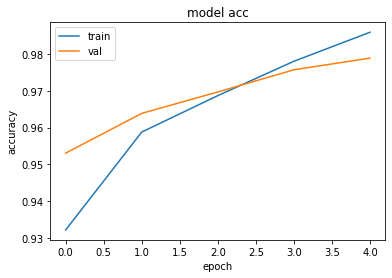

In [ ]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(X_test).argmax(2)

In [ ]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

           O       0.90      0.94      0.92     40480
       B-PER       0.88      0.77      0.82      3542
       I-PER       0.86      0.88      0.87      7544
       B-ORG       0.67      0.55      0.61      4074
       I-ORG       0.79      0.72      0.75      8008
       B-LOC       0.60      0.61      0.61      4560
       I-LOC       0.63      0.60      0.61      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.79      0.76      0.77    540000
weighted avg       0.98      0.98      0.98    540000



In [ ]:
label_seq('Моуринью утешает Пепа после поражения "Барселоны" от "Интера" в полуфинале ЛЧ в 2010 году.', word2id, id2labels, MAX_LEN, model)

1/1 [==============================] - 0s 26ms/step


[('Моуринью', 'O'),
 ('утешает', 'O'),
 ('Пепа', 'O'),
 ('после', 'O'),
 ('поражения', 'O'),
 ('"', 'O'),
 ('Барселоны', 'O'),
 ('"', 'O'),
 ('от', 'O'),
 ('"', 'O'),
 ('Интера', 'O'),
 ('"', 'O'),
 ('в', 'O'),
 ('полуфинале', 'O'),
 ('ЛЧ', 'O'),
 ('в', 'O'),
 ('2010', 'B-LOC'),
 ('году', 'I-ORG'),
 ('.', 'O')]

In [ ]:
label_seq('Дмитрий Аленичев завершает разгром "Монако" в финале-2004.', word2id, id2labels, MAX_LEN, model)

1/1 [==============================] - 0s 24ms/step


[('Дмитрий', 'O'),
 ('Аленичев', 'O'),
 ('завершает', 'O'),
 ('разгром', 'O'),
 ('"', 'O'),
 ('Монако', 'O'),
 ('"', 'O'),
 ('в', 'O'),
 ('финале', 'B-ORG'),
 ('-', 'I-ORG'),
 ('2004', 'I-ORG'),
 ('.', 'O')]

In [ ]:
label_seq('Криштиану забивает "Челси" в финале в Москве.', word2id, id2labels, MAX_LEN, model)

1/1 [==============================] - 0s 45ms/step


[('Криштиану', 'B-LOC'),
 ('забивает', 'O'),
 ('"', 'O'),
 ('Челси', 'O'),
 ('"', 'O'),
 ('в', 'O'),
 ('финале', 'O'),
 ('в', 'O'),
 ('Москве', 'B-LOC'),
 ('.', 'O')]

In [ ]:
label_seq('Виктор Семен Пётр Арагорн', word2id, id2labels, MAX_LEN, model)

1/1 [==============================] - 0s 50ms/step


[('Виктор', 'B-PER'),
 ('Семен', 'I-PER'),
 ('Пётр', 'I-PER'),
 ('Арагорн', 'I-PER')]

Модель с несколькими BIGRU слоями

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

gru_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
gru_2 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(129, return_sequences=True))(gru_1)
gru_3 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(130, return_sequences=True))(gru_2)
gru_4 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(131, return_sequences=True))(gru_3)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(gru_4)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

In [ ]:
model.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=5)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


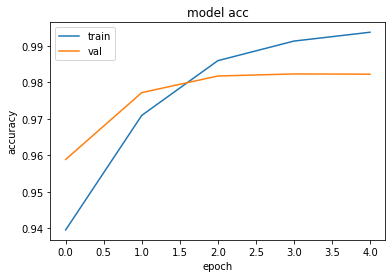

In [ ]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(X_test).argmax(2)

In [ ]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

           O       0.92      0.94      0.93     40480
       B-PER       0.85      0.82      0.84      3542
       I-PER       0.90      0.87      0.89      7544
       B-ORG       0.56      0.71      0.63      4074
       I-ORG       0.79      0.74      0.76      8008
       B-LOC       0.84      0.66      0.74      4560
       I-LOC       0.85      0.72      0.78      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.84      0.81      0.82    540000
weighted avg       0.98      0.98      0.98    540000



In [ ]:
label_seq('Моуринью утешает Пепа после поражения "Барселоны" от "Интера" в полуфинале ЛЧ в 2010 году.', word2id, id2labels, MAX_LEN, model)

1/1 [==============================] - 0s 34ms/step


[('Моуринью', 'B-ORG'),
 ('утешает', 'O'),
 ('Пепа', 'O'),
 ('после', 'O'),
 ('поражения', 'O'),
 ('"', 'O'),
 ('Барселоны', 'B-ORG'),
 ('"', 'O'),
 ('от', 'O'),
 ('"', 'O'),
 ('Интера', 'O'),
 ('"', 'O'),
 ('в', 'O'),
 ('полуфинале', 'O'),
 ('ЛЧ', 'O'),
 ('в', 'O'),
 ('2010', 'B-LOC'),
 ('году', 'I-LOC'),
 ('.', 'O')]

In [ ]:
label_seq('Дмитрий Аленичев завершает разгром "Монако" в финале 2004 года.', word2id, id2labels, MAX_LEN, model)

1/1 [==============================] - 0s 28ms/step


[('Дмитрий', 'B-PER'),
 ('Аленичев', 'I-PER'),
 ('завершает', 'O'),
 ('разгром', 'O'),
 ('"', 'O'),
 ('Монако', 'B-ORG'),
 ('"', 'O'),
 ('в', 'O'),
 ('финале', 'B-ORG'),
 ('2004', 'I-ORG'),
 ('года', 'I-ORG'),
 ('.', 'O')]

In [ ]:
label_seq('Криштиану забивает "Челси" в финале в Москве.', word2id, id2labels, MAX_LEN, model)

1/1 [==============================] - 0s 30ms/step


[('Криштиану', 'O'),
 ('забивает', 'O'),
 ('"', 'O'),
 ('Челси', 'O'),
 ('"', 'O'),
 ('в', 'O'),
 ('финале', 'O'),
 ('в', 'O'),
 ('Москве', 'B-LOC'),
 ('.', 'O')]

In [ ]:
label_seq('Виктор Семен Пётр Арагорн', word2id, id2labels, MAX_LEN, model)

1/1 [==============================] - 0s 28ms/step


[('Виктор', 'B-PER'), ('Семен', 'I-PER'), ('Пётр', 'O'), ('Арагорн', 'O')]

Я пробовала разные комбинации слоев и разное их количество. Из всего того, что я пробовала, финальные варианты (представленные в тетрадке) дали лучшие результаты и по метрикам, и по проверке на примерах. Что касается последнего, модели совсем не могут определить иностранные персоналии и нередко в таком случае приписывают тег ORG. И вообще наблюдается тяготению именно к этому тегу, если уж модель видит в слове именованную сущность.